In [ ]:
import numpy as np
from skfuzzy import control as ctrl
from skfuzzy import membership as mf
import matplotlib.pyplot as plt


In [ ]:
#Define universes (inputs normalized 0-1; output 0-100)
# Inputs: normalized 0.00 - 1.00 with step 0.01
u = np.arange(0.0, 1.001, 0.001)
# Output: 0 - 100 with step 0.2 (dense enough for area integration)
u_out = np.arange(0.0, 100.01, 0.2)

Reflectivity = ctrl.Antecedent(u, 'reflectivity')
Moisture = ctrl.Antecedent(u, 'moisture')
Weight = ctrl.Antecedent(u, 'weight')
Magnetic = ctrl.Antecedent(u, 'magnetic')
Material = ctrl.Consequent(u_out, 'material')

Reflectivity: Low (0–0.3), Medium (0.2–0.7), High (0.6–1.0)

In [ ]:
Reflectivity['low']    = fuzz.trapmf(Reflectivity.universe, [0.0, 0.0, 0.15, 0.3])
Reflectivity['medium'] = fuzz.trimf(Reflectivity.universe, [0.2, 0.45, 0.7])
Reflectivity['high']   = fuzz.trapmf(Reflectivity.universe, [0.6, 0.75, 1.0, 1.0])

Moisture: Dry (0–0.4), Damp (0.3–0.7), Wet (0.6–1.0)

In [ ]:
Moisture['dry']  = fuzz.trapmf(Moisture.universe, [0.0, 0.0, 0.2, 0.4])
Moisture['damp'] = fuzz.trimf(Moisture.universe, [0.3, 0.5, 0.7])
Moisture['wet']  = fuzz.trapmf(Moisture.universe, [0.6, 0.8, 1.0, 1.0])

Weight: Light (0–0.3), Medium (0.2–0.6), Heavy (0.5–1.0)

In [ ]:
Weight['light']  = fuzz.trapmf(Weight.universe, [0.0, 0.0, 0.15, 0.3])
Weight['medium'] = fuzz.trimf(Weight.universe, [0.2, 0.4, 0.6])
Weight['heavy']  = fuzz.trapmf(Weight.universe, [0.5, 0.75, 1.0, 1.0])

Magnetic: Non-magnetic (0–0.2), Weakly Magnetic (0.1–0.6), Strongly Magnetic (0.5–1.0)

In [ ]:
Magnetic['non_magnetic']      = fuzz.trapmf(Magnetic.universe, [0.0, 0.0, 0.05, 0.2])
Magnetic['weakly_magnetic']   = fuzz.trimf(Magnetic.universe, [0.1, 0.3, 0.6])
Magnetic['strongly_magnetic'] = fuzz.trapmf(Magnetic.universe, [0.5, 0.75, 1.0, 1.0])


In [ ]:
Reflectivity.view()
Moisture.view()
Weight.view()
Magnetic.view()
Material.view()


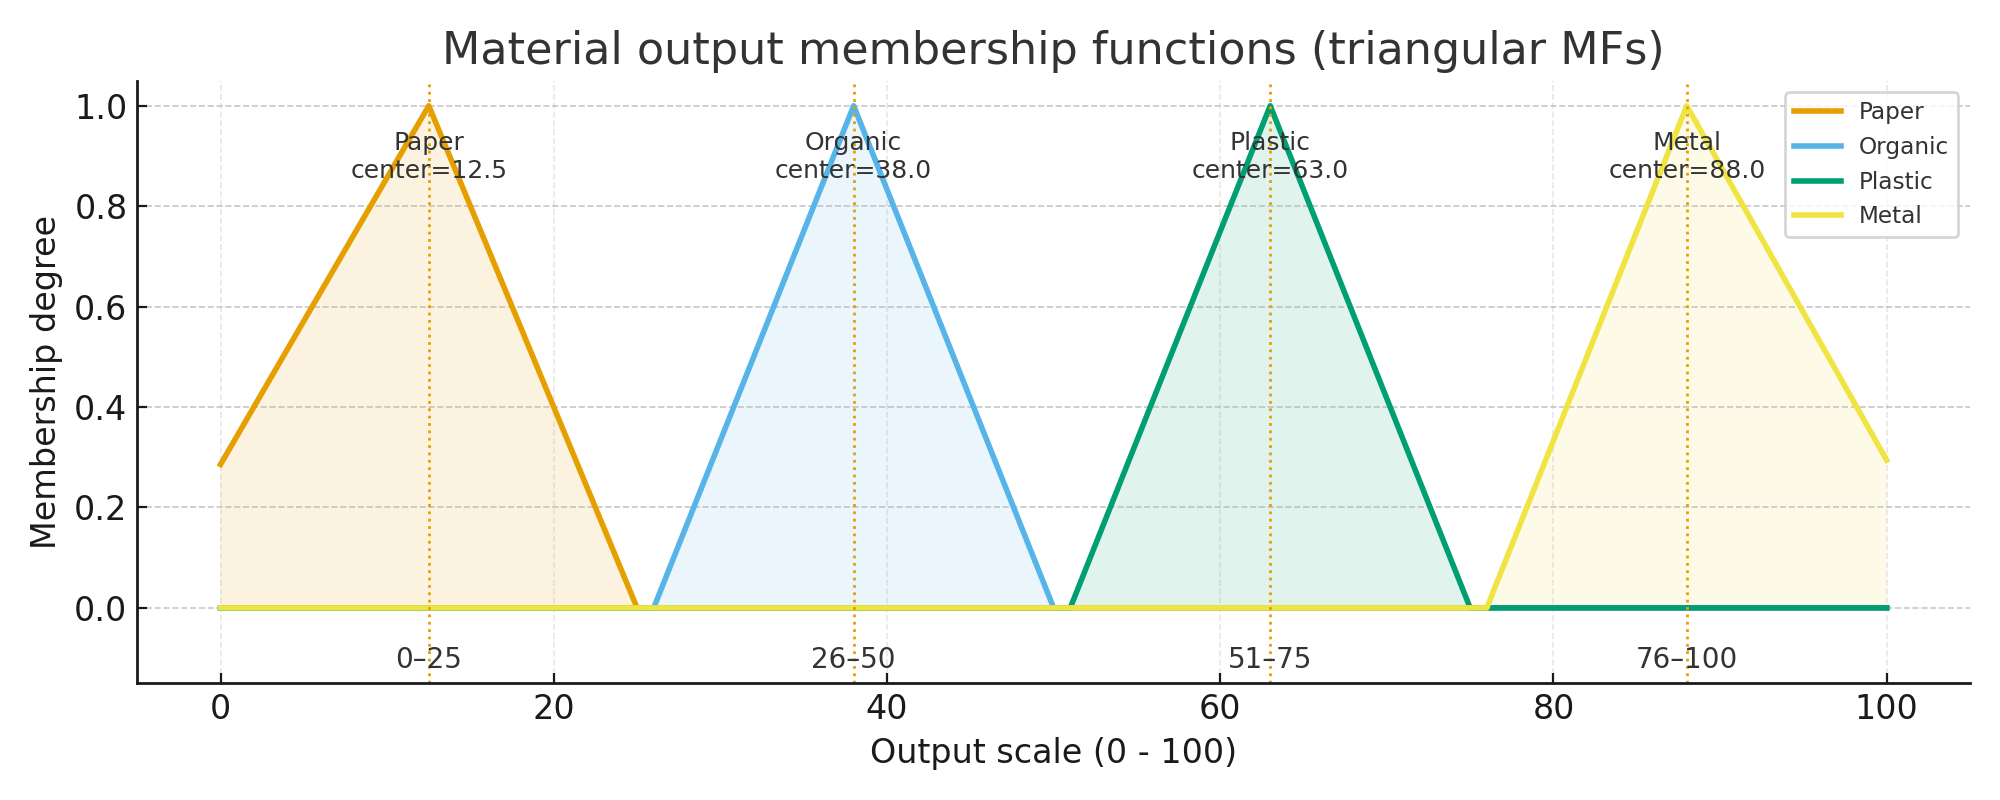

In [ ]:
Material['paper']   = fuzz.trimf(Material.universe, [-5.0, 12.5, 25.0])
Material['organic'] = fuzz.trimf(Material.universe, [26.0, 38.0, 50.0])
Material['plastic'] = fuzz.trimf(Material.universe, [51.0, 63.0, 75.0])
Material['metal']   = fuzz.trimf(Material.universe, [76.0, 88.0, 105.0])


Rules

In [ ]:
rules = []

# If reflectivity is high and moisture is dry and magnetic property is non-magnetic, then Plastic.
rules.append(ctrl.Rule(Reflectivity['high'] & Moisture['dry'] & Magnetic['non_magnetic'], Material['plastic']))

# If reflectivity is medium and moisture is wet and weight is medium, then Organic.
rules.append(ctrl.Rule(Reflectivity['medium'] & Moisture['wet'] & Weight['medium'], Material['organic']))

# If reflectivity is low and moisture is dry and weight is light, then Paper.
rules.append(ctrl.Rule(Reflectivity['low'] & Moisture['dry'] & Weight['light'], Material['paper']))

# If magnetic property is strongly magnetic, then Metal.
rules.append(ctrl.Rule(Magnetic['strongly_magnetic'], Material['metal']))

# If moisture is damp and weight is medium and reflectivity is medium, then Organic.
rules.append(ctrl.Rule(Moisture['damp'] & Weight['medium'] & Reflectivity['medium'], Material['organic']))

# If reflectivity is high and magnetic property is weakly magnetic, then Metal.
rules.append(ctrl.Rule(Reflectivity['high'] & Magnetic['weakly_magnetic'], Material['metal']))

# If reflectivity is medium and moisture is dry, then Paper or Plastic (two rules with same antecedent)
rules.append(ctrl.Rule(Reflectivity['medium'] & Moisture['dry'], Material['paper']))
rules.append(ctrl.Rule(Reflectivity['medium'] & Moisture['dry'], Material['plastic']))


In [ ]:
material_ctrl = ctrl.ControlSystem(rules)
material_sim  = ctrl.ControlSystemSimulation(material_ctrl)

In [ ]:
def compute_mamdani_areas(input_values):
    """
    input_values: dict with keys 'reflectivity','moisture','weight','magnetic' values in [0,1]
    Returns:
      - aggregated (array on u_out): aggregated MF after max-aggregation
      - per_material (dict of arrays): clipped MFs per material
      - rule_activations (list of tuples): (rule_index, firing_strength, consequent_label)
      - percentages (dict): area-based percentage support per material
    """
    # fuzzify inputs using the Antecedent MFs
    fuzzified = {
        'reflectivity': {k: float(fuzz.interp_membership(Reflectivity.universe, Reflectivity[k].mf, input_values['reflectivity'])) for k in Reflectivity.terms},
        'moisture':     {k: float(fuzz.interp_membership(Moisture.universe, Moisture[k].mf, input_values['moisture'])) for k in Moisture.terms},
        'weight':       {k: float(fuzz.interp_membership(Weight.universe, Weight[k].mf, input_values['weight'])) for k in Weight.terms},
        'magnetic':     {k: float(fuzz.interp_membership(Magnetic.universe, Magnetic[k].mf, input_values['magnetic'])) for k in Magnetic.terms},
    }

    # Prepare per-material containers
    per_material = {m: np.zeros_like(Material.universe) for m in Material.terms}
    rule_activations = []

    # Evaluate each rule as in Mamdani: min for AND, clip consequent MF by firing strength, aggregate with max
    for i, r in enumerate(rules):
        antecedent = r.antecedent
        consequent = r.consequent
        if i == 0:
            # rule 0: Reflectivity['high'] & Moisture['dry'] & Magnetic['non_magnetic'] -> Plastic
            strength = min(fuzzified['reflectivity']['high'],
                           fuzzified['moisture']['dry'],
                           fuzzified['magnetic']['non_magnetic'])
            cons = 'plastic'
        elif i == 1:
            # rule 1: Reflectivity['medium'] & Moisture['wet'] & Weight['medium'] -> Organic
            strength = min(fuzzified['reflectivity']['medium'],
                           fuzzified['moisture']['wet'],
                           fuzzified['weight']['medium'])
            cons = 'organic'
        elif i == 2:
            # rule 2: Reflectivity['low'] & Moisture['dry'] & Weight['light'] -> Paper
            strength = min(fuzzified['reflectivity']['low'],
                           fuzzified['moisture']['dry'],
                           fuzzified['weight']['light'])
            cons = 'paper'
        elif i == 3:
            # rule 3: Magnetic['strongly_magnetic'] -> Metal
            strength = fuzzified['magnetic']['strongly_magnetic']
            cons = 'metal'
        elif i == 4:
            # rule 4: Moisture['damp'] & Weight['medium'] & Reflectivity['medium'] -> Organic
            strength = min(fuzzified['moisture']['damp'],
                           fuzzified['weight']['medium'],
                           fuzzified['reflectivity']['medium'])
            cons = 'organic'
        elif i == 5:
            # rule 5: Reflectivity['high'] & Magnetic['weakly_magnetic'] -> Metal
            strength = min(fuzzified['reflectivity']['high'],
                           fuzzified['magnetic']['weakly_magnetic'])
            cons = 'metal'
        elif i == 6:
            # rule 6: Reflectivity['medium'] & Moisture['dry'] -> Paper
            strength = min(fuzzified['reflectivity']['medium'],
                           fuzzified['moisture']['dry'])
            cons = 'paper'
        elif i == 7:
            # rule 7: Reflectivity['medium'] & Moisture['dry'] -> Plastic
            strength = min(fuzzified['reflectivity']['medium'],
                           fuzzified['moisture']['dry'])
            cons = 'plastic'
        else:
            strength = 0.0
            cons = None

        rule_activations.append((i, float(strength), cons))
        if strength > 0 and cons is not None:
            # Clip the consequent MF on the u_out universe
            cons_mf = Material[cons].mf.copy()  # base MF on u_out
            clipped = np.minimum(cons_mf, strength)
            # Aggregate by max
            per_material[cons] = np.maximum(per_material[cons], clipped)

    # Overall aggregated output (union of per-materials)
    aggregated = np.zeros_like(u_out)
    for arr in per_material.values():
        aggregated = np.maximum(aggregated, arr)

    # Compute areas and percentages
    areas = {m: float(np.trapz(per_material[m], u_out)) for m in per_material}
    total_area = sum(areas.values())
    if total_area <= 0:
        percentages = {m: 0.0 for m in areas}
    else:
        percentages = {m: 100.0 * areas[m] / total_area for m in areas}

    return aggregated, per_material, rule_activations, fuzzified, percentages


In [ ]:
demo_cases = [
    {"reflectivity": 0.85, "moisture": 0.10, "weight": 0.25, "magnetic": 0.00},  # expected Plastic
    {"reflectivity": 0.40, "moisture": 0.65, "weight": 0.45, "magnetic": 0.05},  # expected Organic
    {"reflectivity": 0.20, "moisture": 0.25, "weight": 0.35, "magnetic": 0.90},  # expected Metal
    {"reflectivity": 0.35, "moisture": 0.20, "weight": 0.25, "magnetic": 0.10},  # expected Paper
]

for i, case in enumerate(demo_cases, 1):
    material_sim.input['reflectivity'] = case['reflectivity']
    material_sim.input['moisture']     = case['moisture']
    material_sim.input['weight']       = case['weight']
    material_sim.input['magnetic']     = case['magnetic']
    material_sim.compute()
    crisp_out = material_sim.output['material']

    # manual Mamdani clipped outputs -> percentages
    aggregated, per_material, activations, fuzzified, percentages = compute_mamdani_areas(case)

    # Map crisp to label
    if crisp_out <= 25:
        crisp_label = 'Paper'
    elif crisp_out <= 50:
        crisp_label = 'Organic'
    elif crisp_out <= 75:
        crisp_label = 'Plastic'
    else:
        crisp_label = 'Metal'

    print(f"Case {i}: inputs = {case}")
    print("  Fuzzified inputs (degrees):")
    for vname, d in fuzzified.items():
        print(f"    {vname}: { {k: round(v,3) for k,v in d.items()} }")
    print("  Rule activations (index, strength, consequent):")
    for act in activations:
        if act[1] > 0:
            print(f"    {act}")
    print(f"  Crisp output (skfuzzy control): {crisp_out:.2f} -> {crisp_label}")
    print("  Area-based material percentages (Mamdani clipped):")
    for m, p in percentages.items():
        print(f"    {m}: {p:.1f}%")
    print()

    # Plot aggregated and per-material clipped MFs (optional visualization)
    plt.figure(figsize=(7,3))
    plt.plot(u_out, aggregated, label='Aggregated (union)', linewidth=2)
    for m in per_material:
        plt.plot(u_out, per_material[m], '--', label=f"{m} clipped")
    plt.title(f"Case {i} - Aggregated output membership")
    plt.xlabel("Output scale (0-100)")
    plt.ylabel("Membership degree")
    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.show()
